In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xls_data=pd.read_excel("./table.xlsx")
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

In [3]:
def data_restore(dat):
    for col_name in dat.columns[:5]:
        temp=0
        for i in range(len(dat[col_name])):
            if (dat.loc[i,col_name]!=0):
                temp=dat.loc[i,col_name]
            if (dat.loc[i,col_name]==0):
                dat.loc[i,col_name]=temp
    return dat
t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

In [4]:
total_dat_temp=np.vstack([t2_dat.values,t3_dat.values,t4_dat.values])
del_index=np.where(total_dat_temp[:,6]==0)[0]
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)
total_dat=total_dat_temp.drop(del_index)
total_dat.to_csv("preprocessed_data.csv",
                 columns=total_dat.columns,sep=",", index=False)
data=total_dat.values

In [5]:
dat_x = data[:,:6]
max_x = np.max(dat_x,axis=0)
print('scale factors:',max_x)
dat_x = dat_x/max_x
dat_y = data[:,6]
log_dat_x=np.log(dat_x)
log_dat_y=np.log(dat_y)
n_data = len(dat_y)

scale factors: [ 4.  50.   0.3  0.6  8.  32. ]


In [6]:
add_feat = np.zeros((n_data,21))
cnt = 0
for i in range(6):
    for j in range(i,6):
        add_feat[:,cnt] = log_dat_x[:,i]*log_dat_x[:,j]
        cnt = cnt + 1
x_train = np.hstack( ( np.ones((n_data,1)), log_dat_x, add_feat ) )
y_train = log_dat_y

---

## Model

We assume 

$$
\log(v) \approx b + \sum_{i=1}^{6}\left( \theta_i \log u_i + \beta_i u_i \right)
$$

or,

$$
    v \approx e^b \prod_{i=1}^{6}u_i^{\theta_i} (e^{\beta_i})^{u_i}
$$

where

- $u_1$: n_turns/4 
- $u_2$: permitivity_surface/50
- $u_3$: LS_LW/0.3
- $u_4$: SEP/0.6
- $u_5$: permitivity_subsidence/8
- $u_6$: OD/32
- $v$: HFSS
- decision variables: $b$, $\theta_1, \dots, \theta_6$, $\beta_1, \dots, \beta_6$


## Least squares solution

Solve

$$
    \text{minimize}\quad  \| X_\text{train}\theta-y_\text{train} \|^2 
$$

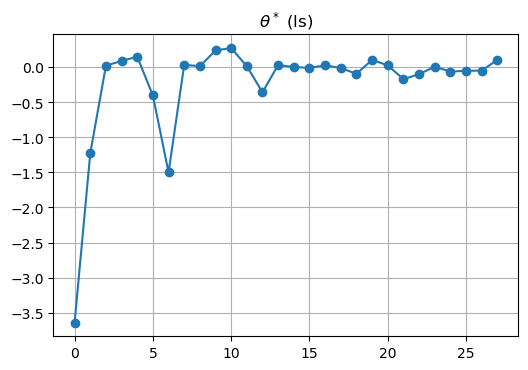

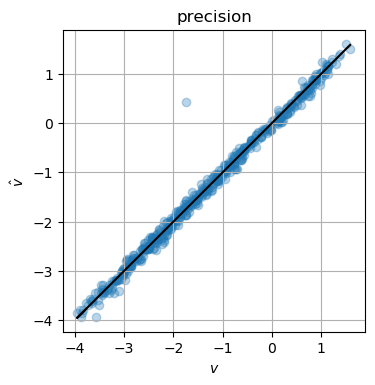

MSE: 0.018174096090115437
RMSE: 0.13481133516924843
Percentage error: 14.43208708808854 %


In [7]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.title('precision')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


___

### Outlier rejection

In [8]:
# finding the outlier
np.argmax(y_pred-y_train)

100

In [9]:
# remove it
x_train = np.delete(x_train,100,0)
y_train = np.delete(y_train,100,0)
n_data = len(y_train)

Solution with outlier rejected:

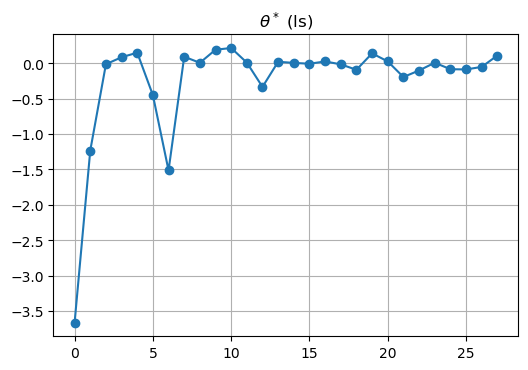

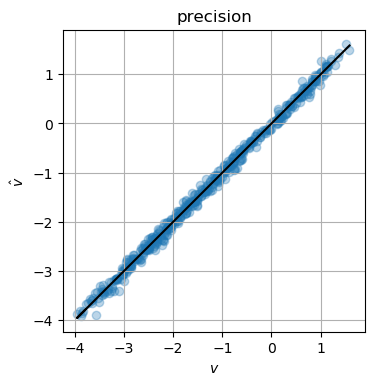

MSE: 0.00745227068451366
RMSE: 0.08632653522824636
Percentage error: 9.016224657004956 %


In [10]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.title('precision')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


### Sparse modeling

Solve

$$
    \text{minimize}\quad  \| X_\text{train}\theta-y_\text{train} \|^2 + \gamma\|\theta_{2:d}\|_1
$$

In [11]:
import cvxpy as cp

gamma = cp.Parameter(nonneg=True)
theta = cp.Variable(x_train.shape[1])
err = cp.sum_squares(x_train*theta-y_train)/n_data

obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + gamma*cp.norm(theta[1:],1) )
prob = cp.Problem(obj)

gamma_vals = np.logspace(-2,1,100)
mse = []
card = []

for val in gamma_vals:
    gamma.value = val
    prob.solve(solver=cp.ECOS, verbose=False)
    mse.append(err.value)
    card.append(np.sum((abs(theta.value)>1e-6)))


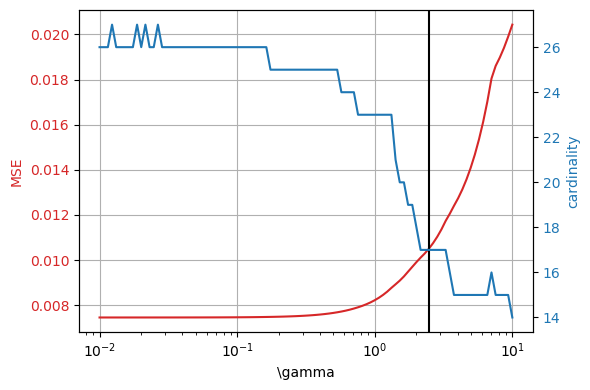

In [12]:
#fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel(r'\gamma')
ax1.set_ylabel('MSE', color=color)
ax1.semilogx(gamma_vals, mse, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.axvline(2.5, color='k')

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('cardinality', color=color)  
ax2.semilogx(gamma_vals, card, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

### we choose $\gamma=2.5$

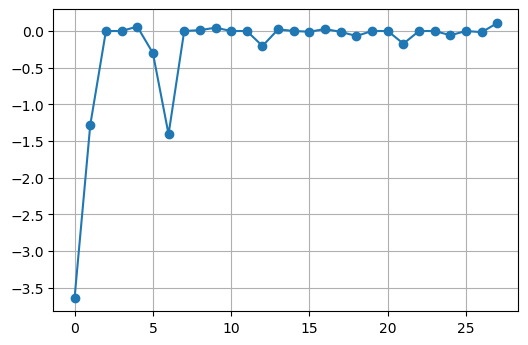

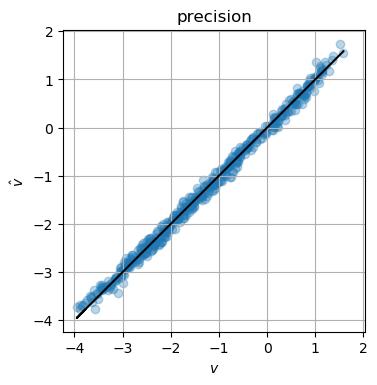

MSE: 0.010535363703080874
RMSE: 0.10264191981388926
Percentage error: 10.809455132363244 %


In [13]:
import cvxpy as cp

theta = cp.Variable(x_train.shape[1])
obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + 2.5*cp.norm(theta[1:],1) )

prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS, verbose=False)
theta_opt = theta.value

plt.figure(dpi=100)
plt.plot(theta_opt,'o-')
plt.grid()
plt.show()

y_pred = x_train.dot(theta_opt)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.title('precision')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')

In [14]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})
print('b_opt:', theta_opt[0])
print('theta_opt:', theta_opt[1:7])
print('beta_opt:', theta_opt[7:])
print('b_opt_exp:', np.exp(theta_opt[0]))
print('beta_opt_exp:', np.exp(theta_opt[7:]))

b_opt: -3.6347777042589917
theta_opt: [-1.28108 -0.00000 0.00000 0.06036 -0.30066 -1.40682]
beta_opt: [0.00000 0.01155 0.04483 0.00000 0.00000 -0.20460 0.02282 -0.00000
 -0.01007 0.02703 -0.01229 -0.06792 0.00000 0.00000 -0.17324 -0.00000
 -0.00000 -0.05785 0.00000 -0.01586 0.10902]
b_opt_exp: 0.026389800075604108
beta_opt_exp: [1.00000 1.01162 1.04586 1.00000 1.00000 0.81497 1.02308 1.00000 0.98998
 1.02739 0.98779 0.93434 1.00000 1.00000 0.84093 1.00000 1.00000 0.94380
 1.00000 0.98426 1.11519]


### Final model

\begin{align*}
\log(HFSS) &\approx -3.635
-1.281\log{n} +0.06036\log{d} -0.3007\log{\nu} -1.407\log{\alpha} \\
& + \log{\alpha}
\left(
-0.2046\log{n} -0.01229\log{\lambda} -0.17324\log{L} -0.05785\log{d} -0.01586\log{\nu}
+0.10902\log{\alpha}
\right) \\
&\qquad 
+\log{\lambda}
\left(   
0.01155\log{n} +0.02282\log{\lambda} -0.0107\log{d} +0.02703\log{\nu}
\right) \\
&\qquad
+\log{L}\left( 0.04483\log{n} -0.06792\log{L} \right)  
\end{align*}

- $n$: n_turns/4 
- $\lambda$: permitivity_surface/50
- $L$: LS_LW/0.3
- $d$: SEP/0.6
- $\nu$: permitivity_subsidence/8
- $\alpha$: OD/32

## Evaluation

In [15]:
xls_data=pd.read_excel("./evaluate_data.xlsx")
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

total_dat_temp=np.vstack([t2_dat.values,t3_dat.values,t4_dat.values])
del_index=np.where(total_dat_temp[:,6]==0)[0]
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)
total_dat=total_dat_temp.drop(del_index)
data=total_dat.values

In [16]:
dat_x = data[:,:6]
dat_x = dat_x/max_x
dat_y = data[:,6]
log_dat_x=np.log(dat_x)
log_dat_y=np.log(dat_y)

n_data = len(dat_y)

add_feat = np.zeros((n_data,21))
cnt = 0
for i in range(6):
    for j in range(i,6):
        add_feat[:,cnt] = log_dat_x[:,i]*log_dat_x[:,j]
        cnt = cnt + 1
x_test = np.hstack( ( np.ones((n_data,1)), log_dat_x, add_feat ) )
y_test = log_dat_y


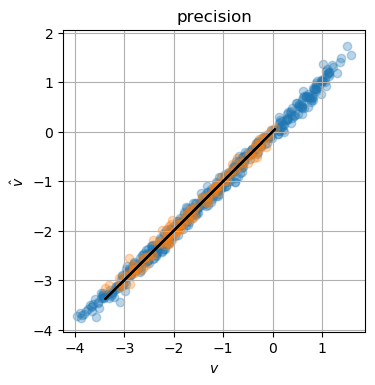

MSE: 0.009241096588009708
RMSE: 0.0961306225300227
Percentage error: 10.090285731898273 %


In [17]:
y_pred_test = x_test.dot(theta_opt)
mse_test = np.linalg.norm(y_test - y_pred_test)**2/n_data

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot(y_test,y_test,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.title('precision')
plt.grid()
plt.show()

print('MSE:',mse_test)
print('RMSE:', np.sqrt(mse_test))
print('Percentage error:', (np.exp(np.sqrt(mse_test))-1)*100,'%')